In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import vapeplot 
from scipy import interp
import scipy.stats
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

#### Goal
--------------------

The goal of this project is to make a classifier that predicts the final rankings for bakers.
The idea is to make a model for each episode and to use data from previous episodes in the model.
Therefore, a classifier for episode 1 will likely be bad at predicting the final outcome, but a classifier for episode 5 might accurately predict who will be in the top 3 and who might be eliminated in the next episode



In [5]:
from datetime import datetime
def timestamp(): return datetime.today().strftime('%Y%m%d')

from sklearn.preprocessing import QuantileTransformer
def quantile_scale(df,feats):
    qua = df
    scaler = QuantileTransformer(
        n_quantiles=10,
        random_state=42,
        ignore_implicit_zeros=True, #sparse matrix
    )
    # fit the scaler
    scaler.fit(qua[feats])
    # transform values
    qua[feats] = scaler.transform(qua[feats])
    return qua
def tiered(classes):
    trans = []
    for x in classes:
        if x==1: c=0
        if x==2: c=1
        if x>=3 and x<=4: c=2
        if x>=5 and x<=7: c=3
        if x>=8: c=4
        trans.append(c)
    return trans

In [3]:
merge_col = ['season','baker','index','episode','place']
tech = pd.read_csv("../RESULTS/gbbo.techinical.data.s10.20191026.tsv",sep="\t")
star = pd.read_csv("../RESULTS/gbbo.starbaker.data.s10.e9.20191026.tsv",sep="\t")
gbbo = pd.merge(tech, star,  how='left', left_on=merge_col, right_on =merge_col)
gbbo = gbbo[['season','baker','episode','place','tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']]
gbbo.to_csv("../RESULTS/gbbo.features.s10.e9.{}.tsv".format(timestamp()),sep="\t",index=False)
gbbo.head()

,season,baker,episode,place,tech_mean,tech,mean_star,star,mean_good,good,mean_bad,bad
0,10,Alice,1,0,5.00,5,0.00,0,0.00,0,0.00,0
1,10,Alice,2,0,3.00,1,0.50,1,0.50,1,0.00,0
2,10,Alice,3,0,4.33,7,0.33,0,0.33,0,0.33,1
3,10,Alice,4,0,5.25,8,0.25,0,0.25,0,0.25,0
4,10,Alice,5,0,5.40,6,0.20,0,0.20,0,0.20,0


In [6]:
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e9.20191026.tsv",sep="\t")
feats = ['tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']
max_epi = max(gbbo['episode'])
gbbo = gbbo.loc[gbbo['episode']==max_epi]
gbbo = quantile_scale(gbbo,feats)
gbbo.head()

,season,baker,episode,place,tech_mean,tech,mean_star,star,mean_good,good,mean_bad,bad
8,10,Alice,9,0,8.670635e-01,9.999999e-01,8.888889e-01,9.999999e-01,8.137255e-01,9.999999e-01,3.888889e-01,1.000000e-07
17,10,Amelia,9,10,1.111111e-01,1.000000e-07,6.666667e-01,1.000000e-07,5.555556e-01,1.000000e-07,3.888889e-01,1.000000e-07
26,10,Dan,9,12,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,3.888889e-01,1.000000e-07
35,10,David,9,0,4.836601e-01,8.333333e-01,1.000000e-07,1.000000e-07,9.098361e-01,1.000000e-07,1.000000e-07,1.000000e-07
44,10,Helena,9,8,8.958333e-01,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,3.888889e-01,1.000000e-07


In [8]:
tech = pd.read_csv("../RESULTS/gbbo.features.20190909.tsv",sep='\t')
tech = tech.loc[tech['episode']==max_epi]
qua = quantile_scale(tech,feats)
qua['place']=tiered(qua['place'])
X, y = np.matrix(qua[feats]), np.array(qua['place'])

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.activations import relu
input_shape = len(feats)
output_shape = len(set(tech['place']))
def create_model( nl1=1, nl2=1,  nl3=1, 
                 nn1=1000, nn2=500, nn3 = 200, lr=0.01, decay=0., l1=0.01, l2=0.01,
                act = 'relu', dropout=0,input_shape=input_shape,output_shape=output_shape):    
    '''This is a model generating function so that we can search over neural net 
    parameters and architecture
    https://www.kaggle.com/arrogantlymodest/randomised-cv-search-over-keras-neural-network
    '''
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999,  decay=decay)
    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)
    model = Sequential()
    first=True  
    for i in range(nl1):
        if first:
            model.add(Dense(nn1, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn1, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))    
    for i in range(nl2):
        if first:
            model.add(Dense(nn2, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn2, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))    
    for i in range(nl3):
        if first:
            model.add(Dense(nn3, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn3, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))       
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'],)
    return model
##################################
l1 = 0.0001
l2 = 0.0001
lr = 0.0001
nl1 = 1
nl2 = 1
nl3 = 1
nn1 = 800
nn2 = 800
nn3 = 300

dropout = 0.1
decay = 1e-09
act='relu'
n_dims = len(feats)
n_classes = len(set(tech['place']))

nn = create_model( nl1=nl1, nl2=nl2,  nl3=nl3, 
                     nn1=nn1, nn2=nn2, nn3 = nn3, 
                     lr=lr, decay=decay, l1=l1, l2=l2,
                     act = act, dropout=dropout,
                     input_shape=n_dims,
                     output_shape=n_classes)

BATCH,EPOCHS = 12, 25
####
X, y = np.matrix(qua[feats]), np.array(qua['place'])
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e9.20191026.tsv",sep="\t")
feats = ['tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']
max_epi = max(gbbo['episode'])
gbbo = gbbo.loc[gbbo['episode']==max_epi]
gbbo = quantile_scale(gbbo,feats)
test = np.matrix(gbbo[feats])

tech = pd.read_csv("../RESULTS/gbbo.features.20190909.tsv",sep='\t')
tech = tech.loc[tech['episode']==max_epi]
qua = quantile_scale(tech,feats)
qua['place']=tiered(qua['place'])
nn.fit(X,y,validation_split=0., batch_size=BATCH, epochs=EPOCHS,verbose=0)

preds = nn.predict_classes(test)
probs = nn.predict_proba(test)
gbbo['preds']=preds
# probability baker is a finalist
top = probs[:,0]
# probability baker is a finalist or a runner-up
top3 = probs[:,0]+probs[:,1]
# bottom tier (8th and below)
bot = probs[:,-1]
# 5th - 7th
nextbot = probs[:,-2]
third = probs[:,-3]

gbbo['bottom']=np.round(bot*100,decimals=2)
gbbo['finalist']=np.round(top*100,decimals=2) 
gbbo['top3'] = np.round(top3*100,decimals=2)
gbbo['fifthseventh'] = np.round(nextbot*100,decimals=2)
gbbo['thirdforth'] = np.round(third*100,decimals=2)

gbbo.to_csv("../RESULTS/gbbo.techinical.s10.e9.keras.preditions.txt",sep="\t",index=False)
sub = ['baker','preds','finalist','top3','bottom','fifthseventh','thirdforth']
gbbo = gbbo[sub].sort_values(by=['finalist'],ascending=False)
print(gbbo)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
        baker  preds   finalist       top3     bottom  fifthseventh  \
35      David      1  28.709999  68.510002   2.890000      6.830000   
116     Steph      1  24.469999  97.459999   0.120000      0.560000   
8       Alice      1  21.969999  98.360001   0.050000      0.360000   
17     Amelia      3   6.640000  11.240000  22.420000     40.959999   
107     Rosie      2   5.740000   8.330000   3.930000      7.630000   
26        Dan      4   2.130000   3.330000  65.790001     22.180000   
53      Henry      3   1.460000   2.160000  24.510000     51.990002   
44     Helena      3   0.880000   1.390000  25.940001     61.750000   
89       Phil      4   0.830000   1.230000  59.939999     31.469999   
80   Michelle      4   0.760000   1.130000  54.810001  

In [8]:
gbbo = gbbo[sub].sort_values(by=['thirdforth'],ascending=False)
print(gbbo)

        baker  preds   finalist       top3     bottom  fifthseventh  \
107     Rosie      2   4.640000   8.800000   2.600000      5.620000   
71    Michael      3   0.790000   1.980000   7.460000     63.220001   
17     Amelia      3   6.280000  13.110000  22.250000     40.570000   
53      Henry      3   1.450000   2.980000  24.690001     50.689999   
35      David      1  25.629999  71.349998   2.540000      5.810000   
44     Helena      3   0.880000   2.040000  30.309999     56.209999   
26        Dan      4   2.490000   4.960000  58.020000     27.440001   
80   Michelle      4   0.840000   1.750000  52.680000     37.590000   
89       Phil      4   0.940000   1.920000  56.259998     34.070000   
62      Jamie      4   0.860000   1.710000  63.810001     27.780001   
98      Priya      4   0.250000   0.540000  48.320000     45.040001   
116     Steph      1  22.010000  98.139999   0.090000      0.330000   
8       Alice      1  19.969999  98.779999   0.040000      0.170000   

     

In [8]:
gbbo = gbbo[sub].sort_values(by=['fifthseventh'],ascending=False)
print(gbbo)

        baker  preds   finalist       top3     bottom  fifthseventh  \
63    Michael      3   0.570000   2.250000   6.330000     87.930000   
39     Helena      3   0.300000   1.060000  28.450001     68.910004   
87      Priya      3   0.050000   0.200000  48.360001     50.990002   
71   Michelle      4   0.600000   1.740000  49.709999     46.450001   
15     Amelia      3   8.840000  20.639999  21.930000     44.980000   
79       Phil      4   0.750000   2.030000  59.650002     36.110001   
23        Dan      4   1.270000   3.130000  71.059998     22.980000   
55      Jamie      4   0.300000   0.810000  76.309998     21.830000   
95      Rosie      2   2.510000   5.860000   2.380000      3.090000   
7       Alice      1  16.059999  74.860001   0.610000      2.930000   
31      David      1  22.830000  85.430000   1.060000      1.490000   
47      Henry      2  15.700000  29.080000   0.250000      0.450000   
103     Steph      1  21.959999  95.910004   0.060000      0.200000   

     

In [9]:
gbbo = gbbo[sub].sort_values(by=['thirdforth'],ascending=False)
print(gbbo)

        baker  preds   finalist       top3     bottom  fifthseventh  \
95      Rosie      2   2.510000   5.860000   2.380000      3.090000   
47      Henry      2  15.700000  29.080000   0.250000      0.450000   
7       Alice      1  16.059999  74.860001   0.610000      2.930000   
15     Amelia      3   8.840000  20.639999  21.930000     44.980000   
31      David      1  22.830000  85.430000   1.060000      1.490000   
103     Steph      1  21.959999  95.910004   0.060000      0.200000   
63    Michael      3   0.570000   2.250000   6.330000     87.930000   
23        Dan      4   1.270000   3.130000  71.059998     22.980000   
79       Phil      4   0.750000   2.030000  59.650002     36.110001   
71   Michelle      4   0.600000   1.740000  49.709999     46.450001   
39     Helena      3   0.300000   1.060000  28.450001     68.910004   
55      Jamie      4   0.300000   0.810000  76.309998     21.830000   
87      Priya      3   0.050000   0.200000  48.360001     50.990002   

     

4


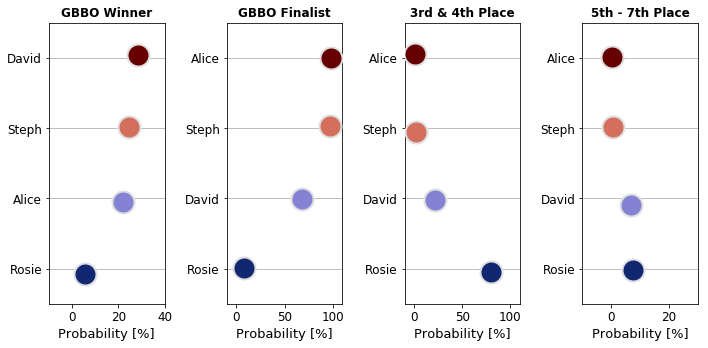

In [11]:
def plot_probs(df,x,xlab,ax,xmin=-9,xmax=100):
    #col=['#012169', '#3d4081', '#64629a', '#8b87b2', '#b1adcc', '#d7d5e5', '#ffffff', '#fddcd9', '#f8b9b4', '#f09790', '#e5736d', '#d84c4d', '#c8102e']
    col=['#122771', '#8483d3', '#d36f5c', '#660000']
    #['#122771', '#8483d3', '#f5f5f5', '#d36f5c', '#660000']
    #['#122771', '#5e62b6', '#a9a6ed', '#f2967f', '#b54839', '#680000']
    #['#122771', '#4b53a4', '#8483d3', '#bcb8fa', '#f5f5f5', '#fcafac', '#f16569', '#c4232d', '#7f0000']
    colrs=reversed(col)

    vapeplot.font_size(12)
    #f, ax = plt.subplots(1,1,figsize=(2.5,5*2.5))
    sns.stripplot(
        y='baker',
        x=x,
        data=df,
        linewidth=2, 
        edgecolor="#dfdfdf",
        size=22,
        ax=ax,
        palette=colrs
    )
    ax.set_ylabel('')
    ax.yaxis.grid(True)
    ax.set_xlim(xmin,xmax)
    ax.set_title(xlab,fontsize=12,weight='bold')
    ax.set_xlabel('Probability [%]',fontsize=13)

nrow=1
ncol=4
lost = ['Dan','Jamie','Amelia','Phil','Helena','Michelle','Priya','Michael','Henry']
gbbo = gbbo.loc[~gbbo['baker'].isin(lost)]
remaining_bakers = len(set(gbbo['baker']))
print(remaining_bakers)
f, ax = plt.subplots(nrow,ncol,figsize=(ncol*2.5,nrow*(remaining_bakers/2)*2.5))

plot_probs(gbbo.sort_values(ascending=False,by=['finalist'])
           ,'finalist','GBBO Winner',ax[0],-10,40)   
plot_probs(gbbo.sort_values(ascending=False,by=['top3']),
           'top3','GBBO Finalist',ax[1],-10,110)
plot_probs(gbbo.sort_values(ascending=True,by=['thirdforth']),
           'thirdforth','3rd & 4th Place',ax[2],-10,110)

plot_probs(gbbo.sort_values(ascending=True,by=['fifthseventh']),
           'fifthseventh','5th - 7th Place',ax[3],-10,30)


#plot_probs(gbbo.sort_values(ascending=True,by=['bottom']),
#           'bottom','8th Place and Below',ax[3],-10,35)

f.tight_layout()
f.savefig('../FIGURES/s10e8.preds.png',dpi=150)
f.show()


In [20]:
gbbo = gbbo[sub].sort_values(by=['top3'],ascending=False)
print(gbbo)

     baker  preds   finalist       top3  bottom  fifthseventh  thirdforth
103  Steph      1  21.959999  95.910004    0.06          0.20    3.830000
31   David      1  22.830000  85.430000    1.06          1.49   12.030000
7    Alice      1  16.059999  74.860001    0.61          2.93   21.610001
47   Henry      2  15.700000  29.080000    0.25          0.45   70.220001
95   Rosie      2   2.510000   5.860000    2.38          3.09   88.660004
